In [2]:
import importlib
import sys

import numpy as np

# Force reload to avoid stale objects
if 'symbolic_bounds' in sys.modules:
    for mod in list(sys.modules.keys()):
        if mod.startswith('symbolic_bounds'):
            del sys.modules[mod]

from symbolic_bounds import DAG, DataGenerator, SCM, ProgramFactory
from symbolic_bounds.random_dag_generator import generate_random_partitioned_dag
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

Generated DAG with 2 nodes


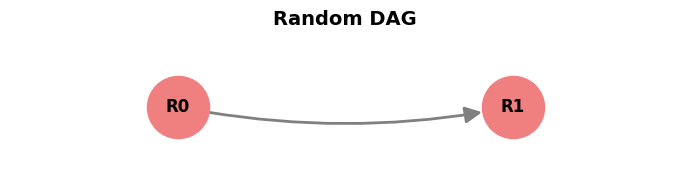

In [ ]:
# 1. Generate a confounding DAG
dag = DAG()
R0 = dag.add_node('R0', support={0, 1})
R1 = dag.add_node('R1', support={0, 1})
# L0 = dag.add_node('L0', support={0, 1}, partition='L')
dag.add_edge(R0, R1)

fig = dag.draw(figsize=(7, 2), title="Confounding DAG", with_labels=True)
plt.show()


In [7]:
dag.generate_all_response_types()
dag.print_response_type_table(R0)
dag.print_response_type_table(R1)


Response types for R0 (no parents):
r_R0^1: R0 = 0
r_R0^2: R0 = 1


Response types for R1 (parents: R0):

r_R1^1:
R0 | R1
-------
0 | 0
1 | 0

r_R1^2:
R0 | R1
-------
0 | 0
1 | 1

r_R1^3:
R0 | R1
-------
0 | 1
1 | 0

r_R1^4:
R0 | R1
-------
0 | 1
1 | 1



In [10]:


# 3. Generate Data
generator = DataGenerator(dag, seed=234)
joint = generator.computeObservedJoint() #Dict[FrozenSet[Tuple[Node, int]], float]
p11 = joint.get(frozenset({(R0, 1), (R1, 1)}))
p10 = joint.get(frozenset({(R0, 1), (R1, 0)}))
generator.print_true_distribution()
print(f'The known tian pearl bounds: [{p11:.4f}, {1-p10:.4f}] for P(R0=1 | do(R1=1))')





TRUE RESPONSE TYPE DISTRIBUTION

Node: R0
----------------------------------------
  P(R_R0 = 0) = 0.190930
  P(R_R0 = 1) = 0.809070
  Total: 1.000000

Node: R1
----------------------------------------
  P(R_R1 = [(R0=0)→0, (R0=1)→0]) = 0.005015
  P(R_R1 = [(R0=0)→0, (R0=1)→1]) = 0.046779
  P(R_R1 = [(R0=0)→1, (R0=1)→0]) = 0.388216
  P(R_R1 = [(R0=0)→1, (R0=1)→1]) = 0.559990
  Total: 1.000000

The known tian pearl bounds: [0.4909, 0.6818] for P(R0=1 | do(R1=1))


In [ ]:
# 4. Create SCM
scm = SCM(dag, generator)

lp = ProgramFactory.write_LP(scm, Y={dag.get_node('R1')}, X={dag.get_node('R0')}, Y_values=(1,), X_values=(1,))

lp.is_minimization = True
# lp.print_decision_variables()
# lp.print_objective()

lb = lp.solve_model(verbose=False).evaluate_objective(np.array([1]))

lp.is_minimization = False
ub = lp.solve_model(verbose=False).evaluate_objective(np.array([1]))
print(f"\nEstimated bounds for P(R0=1 | do(R1=1)): [{lb:.6f}, {ub:.6f}]")


Estimated bounds for P(R0=1 | do(R1=1)): [0.490918, -0.681848]
